<a href="https://colab.research.google.com/github/pegoraro-roberto/NeuralNetworkLab/blob/main/hop_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy.io import loadmat

import pylab as pl
from IPython import display

# Helper functions

In [19]:
def hop_plotdig(P, r=None, c=None, stri=None, ax=None):
    """
    Displays the Hopfield digit stored in P.
    If P is a vector, it must first be reshaped.
    """
    # Se vengono specificate righe e colonne, viene eseguito il reshape del pattern P
    if r is not None and c is not None:
        P = np.reshape(P, (r, c)).T

    # Scala i valori di P per migliorare la visualizzazione
    P = (P + 1) * 64

    # Mostra l'immagine del pattern usando una mappa di colori (colormap) "bone"
    ax.imshow(P, cmap="bone")
    # Rimuove i tick dagli assi per migliorare la leggibilità
    ax.set_xticks([])
    ax.set_yticks([])

    # Aggiunge una label opzionale sull'asse x
    if stri is not None:
        ax.set_xlabel(stri)


def hop_plotpats(P):
    #P è la matrice contentente le caratteristiche delle immagini che formano il training set
    """
    Routine plots the digits for the Hopfield network, the patterns
    are contained in the file hop_data.mat
    """
    # Definisce i nomi delle etichette per i vari pattern
    n1 = "zero"
    n2 = "one"
    n3 = "two"
    n4 = "three"
    n5 = "four"
    n6 = "six"
    n7 = "nine"
    n8 = "block"

    labels = [n1, n2, n3, n4, n5, n6, n7, n8]

    # Crea un grafico con una griglia di subplot
    fig, ax = pl.subplots(3, 3)
    fig.set_size_inches(10, 10)

    # Itera sui pattern e li disegna nei subplot
    for i in range(8):
        #P[:, i] restituisce le caratteristiche che compongono il numero i
        #numero di righe del grafico
        #numero di colonne del grafico
        #label del grafico
        #decide in quale dei 9 grafici di fig vanno inserite queste informazioni (// divisione intera per difetto)
        hop_plotdig(P[:, i], 10, 12, labels[i], ax[i // 3, i % 3])

    fig.show()


def hop_stor(P):
    """
    Performs the storage (learning phase) for a Hopfield network.

    Parameters:
    P - patterns to be stored (column wise matrix)

    Returns:
    W - weight matrix
    """
    # Ottiene le dimensioni della matrice P: numero di neuroni (n) e numero di pattern (p)
    n, p = P.shape

    # Inizializza la matrice dei pesi W come matrice quadrata di zeri
    W = np.zeros((n, n))

    # Calcola i pesi sinaptici secondo la regola di apprendimento di Hebb
    for j in range(1, n):
        for i in range(j):
            W[i, j] = np.dot(P[i, :], P[j, :]) / p  # Prodotto scalare normalizzato
            W[j, i] = W[i, j]  # Simmetria della matrice dei pesi

    return W


def hop_flip(P, prob):
    """
    This routine randomly flips bits in the input pattern (P) according to the
    user specified probability.

    Parameters:
    P - input pattern
    prob - probability of flipping a bit

    Returns:
    P - modified pattern
    flip - number of bits flipped
    """
    # Appiattisce il pattern P in un vettore
    P = P.flatten()
    r = P.shape[0]
    flip = 0  # Contatore per il numero di bit invertiti

    # Per ogni bit nel pattern
    for i in range(r):
        v = np.random.rand()  # Genera un numero casuale
        if v <= prob:  # Con probabilità prob
            flip += 1  # Incrementa il contatore
            P[i] = P[i] * (-1)  # Inverte il bit (da 1 a -1 o viceversa)

    # Riformatta il pattern come matrice colonna
    P = P.reshape(-1, 1)
    return P, flip


def hop_test(W, x, update, plot="on", fig=None, ax=None):
    """
    Parameters:
    W - weight matrix
    x - probe vector
    update - (maximum number of iterations, used to set how often to view the network)
    fig - figure handle
    ax - axis handle

    Returns:
    s - output state vector
    count - number of cycles until stable state is reached
    stable - if this is a stable state (for sure eventually it is)
    """
    # Stato iniziale, appiattito in un vettore
    s_prev = x.flatten()
    count = 0  # Contatore del numero di iterazioni
    stable = False  # Flag per verificare se la rete è stabile
    update = max(update, 1)  # Assicura che ci sia almeno un'iterazione

    while count < update and not stable:
        ch = []  # Lista di cambiamenti
        count += 1  # Incrementa il contatore delle iterazioni

        # Calcola il nuovo stato utilizzando il prodotto matrice-vettore
        #np.sign restituisce +1 se positivo, -1 se negativo, 0 se = a 0
        nv = np.sign(np.dot(W, s_prev))

        # Identifica i neuroni che cambiano stato
        ch = [j for j in range(120) if nv[j] != 0 and abs(nv[j] - s_prev[j]) > 0]

        # Se non ci sono cambiamenti, lo stato è stabile
        if not ch:
            stable = True
            break
        else:
            # Se ci sono cambiamenti, ne seleziona uno casualmente e aggiorna il neurone
            r_ind = np.random.choice(ch)
            s_prev[r_ind] = -s_prev[r_ind]

    # Riformatta lo stato come matrice con la stessa forma di x
    s = s_prev.reshape(x.shape)
    return s, count, stable

# The Hopfield Network - Demo 1 - Pattern Recall

This algorithm demonstrates recall of a corrupted pattern.
The user is prompted for the input pattern and the noise level
as well as an interval at which to show progress of the algorithm.

Loading the digits.

--2025-01-16 21:13:27--  https://github.com/valentinagliozzi/NNCourse/raw/main/hop_data.mat
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/valentinagliozzi/NNCourse/main/hop_data.mat [following]
--2025-01-16 21:13:27--  https://raw.githubusercontent.com/valentinagliozzi/NNCourse/main/hop_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15578 (15K) [application/octet-stream]
Saving to: ‘hop_data.mat’

hop_data.mat        100%[===================>]  15.21K  --.-KB/s    in 0.001s  

2025-01-16 21:13:28 (11.4 MB/s) - ‘hop_data.mat’ saved [15578/15578]



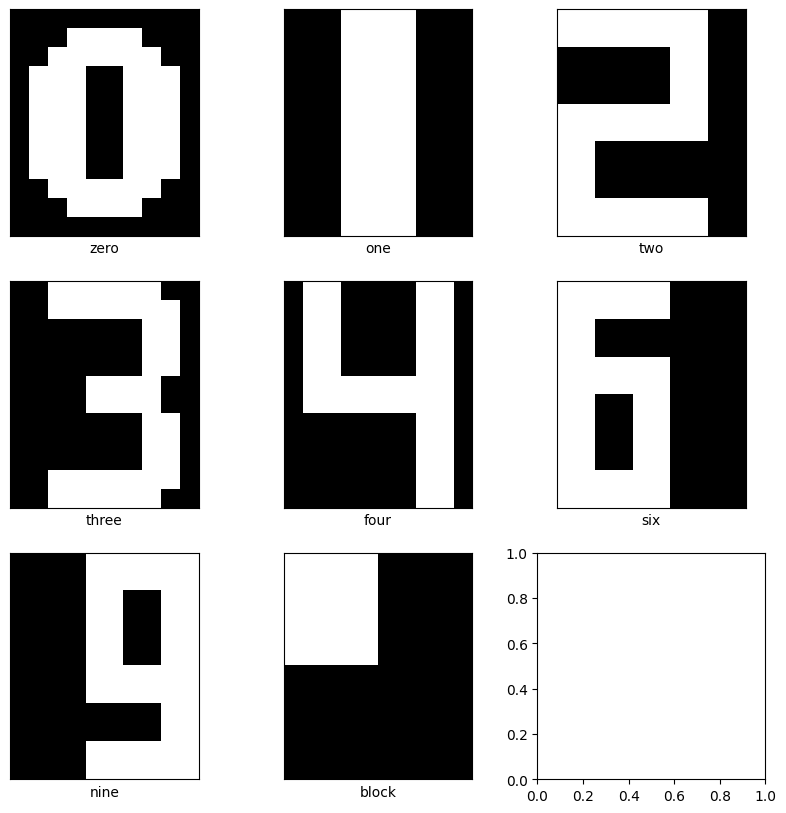

In [20]:
!wget "https://github.com/valentinagliozzi/NNCourse/raw/main/hop_data.mat" -O "hop_data.mat"
data = loadmat("hop_data.mat")
P = data["P"]
hop_plotpats(P)

In [37]:
# ----------------- Calculate Weight Matrix
W = hop_stor(P)

In [38]:
# User options

pat = 4  # pattern to test
pr = 0.2 # probability of flipping a bit (noise level)

u = 5  # number of updates per test run

In [39]:
# Corrupt the pattern with noise

test_pat, flip = hop_flip(P[:, pat - 1], pr)

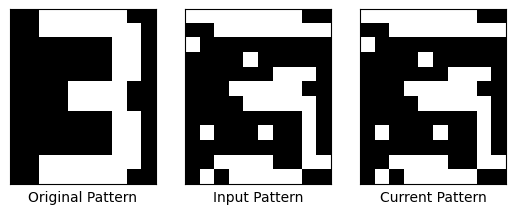

In [40]:
fig, ax = pl.subplots(1, 3)
hop_plotdig(P[:, pat - 1], 10, 12, "Original Pattern", ax=ax[0])
hop_plotdig(test_pat, 10, 12, "Input Pattern", ax=ax[1])
hop_plotdig(test_pat, 10, 12, "Current Pattern", ax=ax[2])

Number of updates for final state: 25


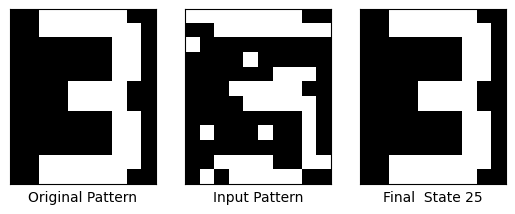

In [41]:
from os import set_inheritable
from time import sleep

# Execute the Hopfield network for u updates. Run again to perform additional updates

for i in range(100):
    test_pat,c,stable = hop_test(W, test_pat, u)
    if not stable:
     ax[2].clear()
     hop_plotdig(test_pat, 10, 12, f"Current State {(i+1)*u}", ax=ax[2])
     display.display(fig)
     display.clear_output(wait=True)
     sleep(0.5)
    else:
     ax[2].clear()
     hop_plotdig(test_pat, 10, 12, f"Final  State {u*(i)+c}", ax=ax[2])
     print(f"Number of updates for final state: {u*(i)+c}")
     display.display(fig)
     display.clear_output(wait=True)
     sleep(0.5)
     break
